### Declare libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
# evaluate an xgboost regression model on the housing dataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,cross_validate,KFold
from xgboost import XGBRegressor
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
import os

### Set folder location of the data and load data 

### Declare functions and select the variables that i am going to use

In [2]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

In [3]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/cornershop_test/data')
# Loading pre-processed dataset
model_data = pd.read_csv('interim/model_data.csv', sep=';')
model_data['is_weighted'] = model_data.KG.apply(lambda x: 1 if x>0 else 0)
model_data['on_demand'] = model_data.on_demand.apply(lambda x: 1 if x>0 else 0)
col_names = ['on_demand', 'is_weighted','UN','picking_speed', 
             'seniority','order_stores_distance','store_district',
             'total_minutes',
            ]                    
X = model_data[col_names]
X.dropna(inplace=True)
y = X.total_minutes
X.drop('total_minutes', axis=1, inplace=True)
X = pd.get_dummies(X)
get_na(X)

,datos sin NAs en q,Na en q,Na en %
on_demand,7983,0,0.0
store_district_Recoleta,7983,0,0.0
store_district_Macul,7983,0,0.0
store_district_Maipú,7983,0,0.0
store_district_Peñalolén,7983,0,0.0
store_district_Providencia,7983,0,0.0
store_district_Provincia de Santiago,7983,0,0.0
store_district_Pudahuel,7983,0,0.0
store_district_Puente Alto,7983,0,0.0
store_district_Quilicura,7983,0,0.0


# tune parameters

<https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/>

In [9]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)
# grid search
n_estimators = [50, 100, 150]
max_depth = [2, 3, 4]
learning_rate = [0.05,0.1,0.3,0.5]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate= learning_rate)
grid_search = GridSearchCV(reg, param_grid, scoring="neg_mean_absolute_error", cv= 10, n_jobs=2, verbose=1)
grid_result = grid_search.fit(X.values, y.values)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [10]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -17.840829 using {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
-19.891826 (0.572634) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
-18.837697 (0.484394) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
-18.416218 (0.470221) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}
-19.020286 (0.597873) with: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
-18.343849 (0.517329) with: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
-18.117812 (0.501636) with: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
-18.586523 (0.578817) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}
-18.115295 (0.497204) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
-17.984415 (0.484498) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150}
-18.817744 (0.480847) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
-18.186801 (0.453581) with: {'le

-17.840828768100224


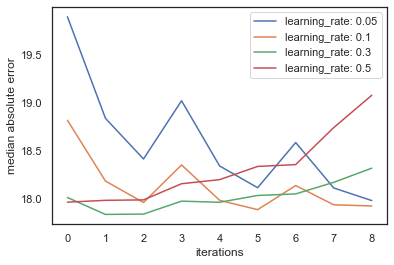

In [17]:
# plot results
print(max(means))
scores = np.array(means).reshape(4, 9)
for i, value in enumerate(learning_rate):
    plt.plot( -scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('iterations')
plt.ylabel('median absolute error')
plt.savefig('iterations vs median absolute error')

-17.840828768100224


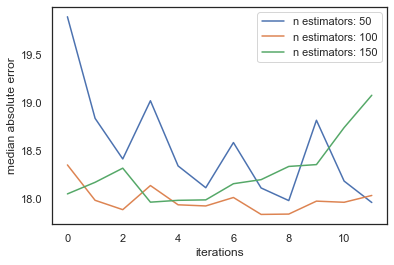

In [20]:
# plot results
print(max(means))
scores = np.array(means).reshape(3, 12)
for i, value in enumerate(n_estimators):
    plt.plot( -scores[i], label='n estimators: ' + str(value))
plt.legend()
plt.xlabel('iterations')
plt.ylabel('median absolute error')
plt.savefig('iterations vs median absolute error')

-17.840828768100224


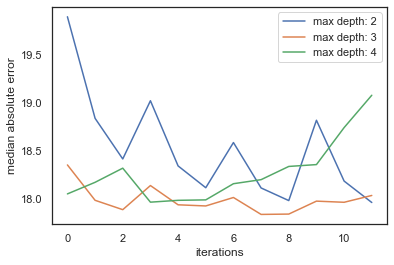

In [21]:
# plot results
print(max(means))
scores = np.array(means).reshape(3, 12)
for i, value in enumerate(max_depth):
    plt.plot( -scores[i], label='max depth: ' + str(value))
plt.legend()
plt.xlabel('iterations')
plt.ylabel('median absolute error')
plt.savefig('iterations vs median absolute error')

In [18]:
params = {
    'tree_method' : "hist",
    'eval_metric' : mean_absolute_error
}
params.update(grid_result.best_params_)
params

{'tree_method': 'hist',
 'eval_metric': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 100}

In [19]:
model = XGBRegressor(**params)
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7fad46272c10>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=None)